# Project - Divvy Bike Database with Microsoft Azure
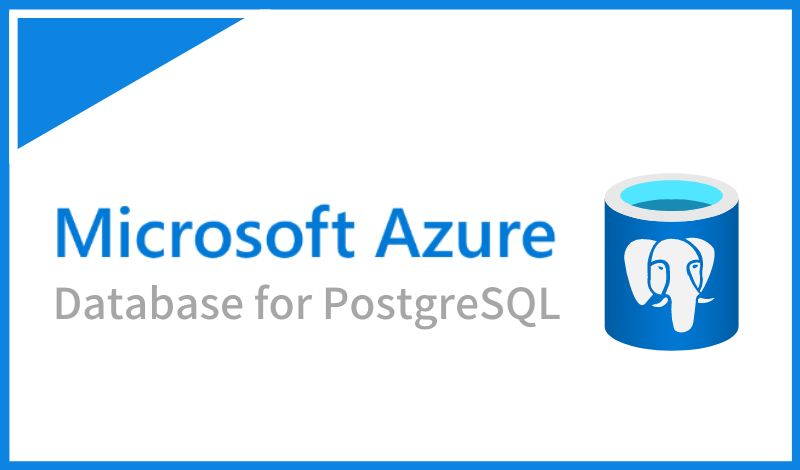

### Overview

### Data Details

### Data Schemas Design

##  1. Load the data into the Postgres SQL server on Microsoft Azure

1. Creating the connection to the server

In [1]:
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT

########################################
# Create the connection string info    #
########################################
host = "postgres-database-flex.postgres.database.azure.com"
user = "admin_user"
password = "WHRdsrs:991028"

# Create a new DB
sslmode = "require"
dbname = "divvy-database-postgres"
conn_string = "host={0} user={1} dbname={2} password={3} sslmode={4}".format(host, user, dbname, password, sslmode)
conn = psycopg2.connect(conn_string)
conn.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT);
print("Connection established")

cursor = conn.cursor()
cursor.execute('DROP DATABASE IF EXISTS divvy_database_postgres')
cursor.execute("CREATE DATABASE divvy_database_postgres")
# Clean up initial connection
conn.commit()
cursor.close()
conn.close()

# Reconnect to the new DB
dbname = "divvy_database_postgres"
conn_string = "host={0} user={1} dbname={2} password={3} sslmode={4}".format(host, user, dbname, password, sslmode)
conn = psycopg2.connect(conn_string)
print("Connection established")
cursor = conn.cursor()


Connection established
Connection established


2. Creating some helper functions to load the data

In [2]:
# Helper functions
# Drop the tables and recreate the table
def drop_recreate(c, tablename, create):
    c.execute("DROP TABLE IF EXISTS {0};".format(tablename))
    c.execute(create)
    print("Finished creating table {0}".format(tablename))

# Fast load the data from CSV files into the postgres database
def populate_table(c, filename, tablename):
    f = open(filename, 'r')
    try:
        ## use copy to bulk load the file into the specified table
        cursor.copy_from(f, tablename, sep=",", null = "")
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
    print("Finished populating {0}".format(tablename))


3. Creating the according tables

In [3]:
# Create Rider table
table = "rider"
filename = './data/riders.csv'
create = "CREATE TABLE rider (rider_id INTEGER PRIMARY KEY, first VARCHAR(50), last VARCHAR(50), address VARCHAR(100), birthday DATE, account_start_date DATE, account_end_date DATE, is_member BOOLEAN);"

drop_recreate(cursor, table, create)
populate_table(cursor, filename, table)

# Create Payment table
table = "payment"
filename = './data/payments.csv'
create = "CREATE TABLE payment (payment_id INTEGER PRIMARY KEY, date DATE, amount MONEY, rider_id INTEGER);"

drop_recreate(cursor, table, create)
populate_table(cursor, filename, table)

# Create Station table
table = "station"
filename = './data/stations.csv'
create = "CREATE TABLE station (station_id VARCHAR(50) PRIMARY KEY, name VARCHAR(75), latitude FLOAT, longitude FLOAT);"

drop_recreate(cursor, table, create)
populate_table(cursor, filename, table)

# Create Trip table
table = "trip"
filename = './data/trips.csv'
create = "CREATE TABLE trip (trip_id VARCHAR(50) PRIMARY KEY, rideable_type VARCHAR(75), start_at TIMESTAMP, ended_at TIMESTAMP, start_station_id VARCHAR(50), end_station_id VARCHAR(50), rider_id INTEGER);"

drop_recreate(cursor, table, create)
populate_table(cursor, filename, table)

# Clean up
conn.commit()
cursor.close()
conn.close()

print("All done!")

Finished creating table rider
Finished populating rider
Finished creating table payment
Finished populating payment
Finished creating table station
Finished populating station
Finished creating table trip
Finished populating trip
All done!


#### After creating the table, check if the table successfully created in the postgres server
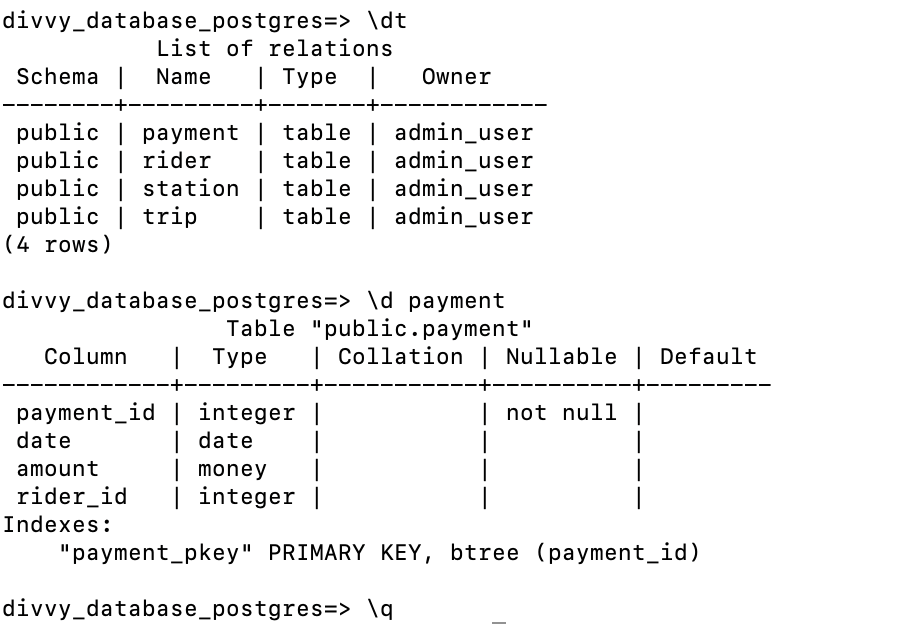

## 2. Extract the data from the Postgres Server into the Blob Storage
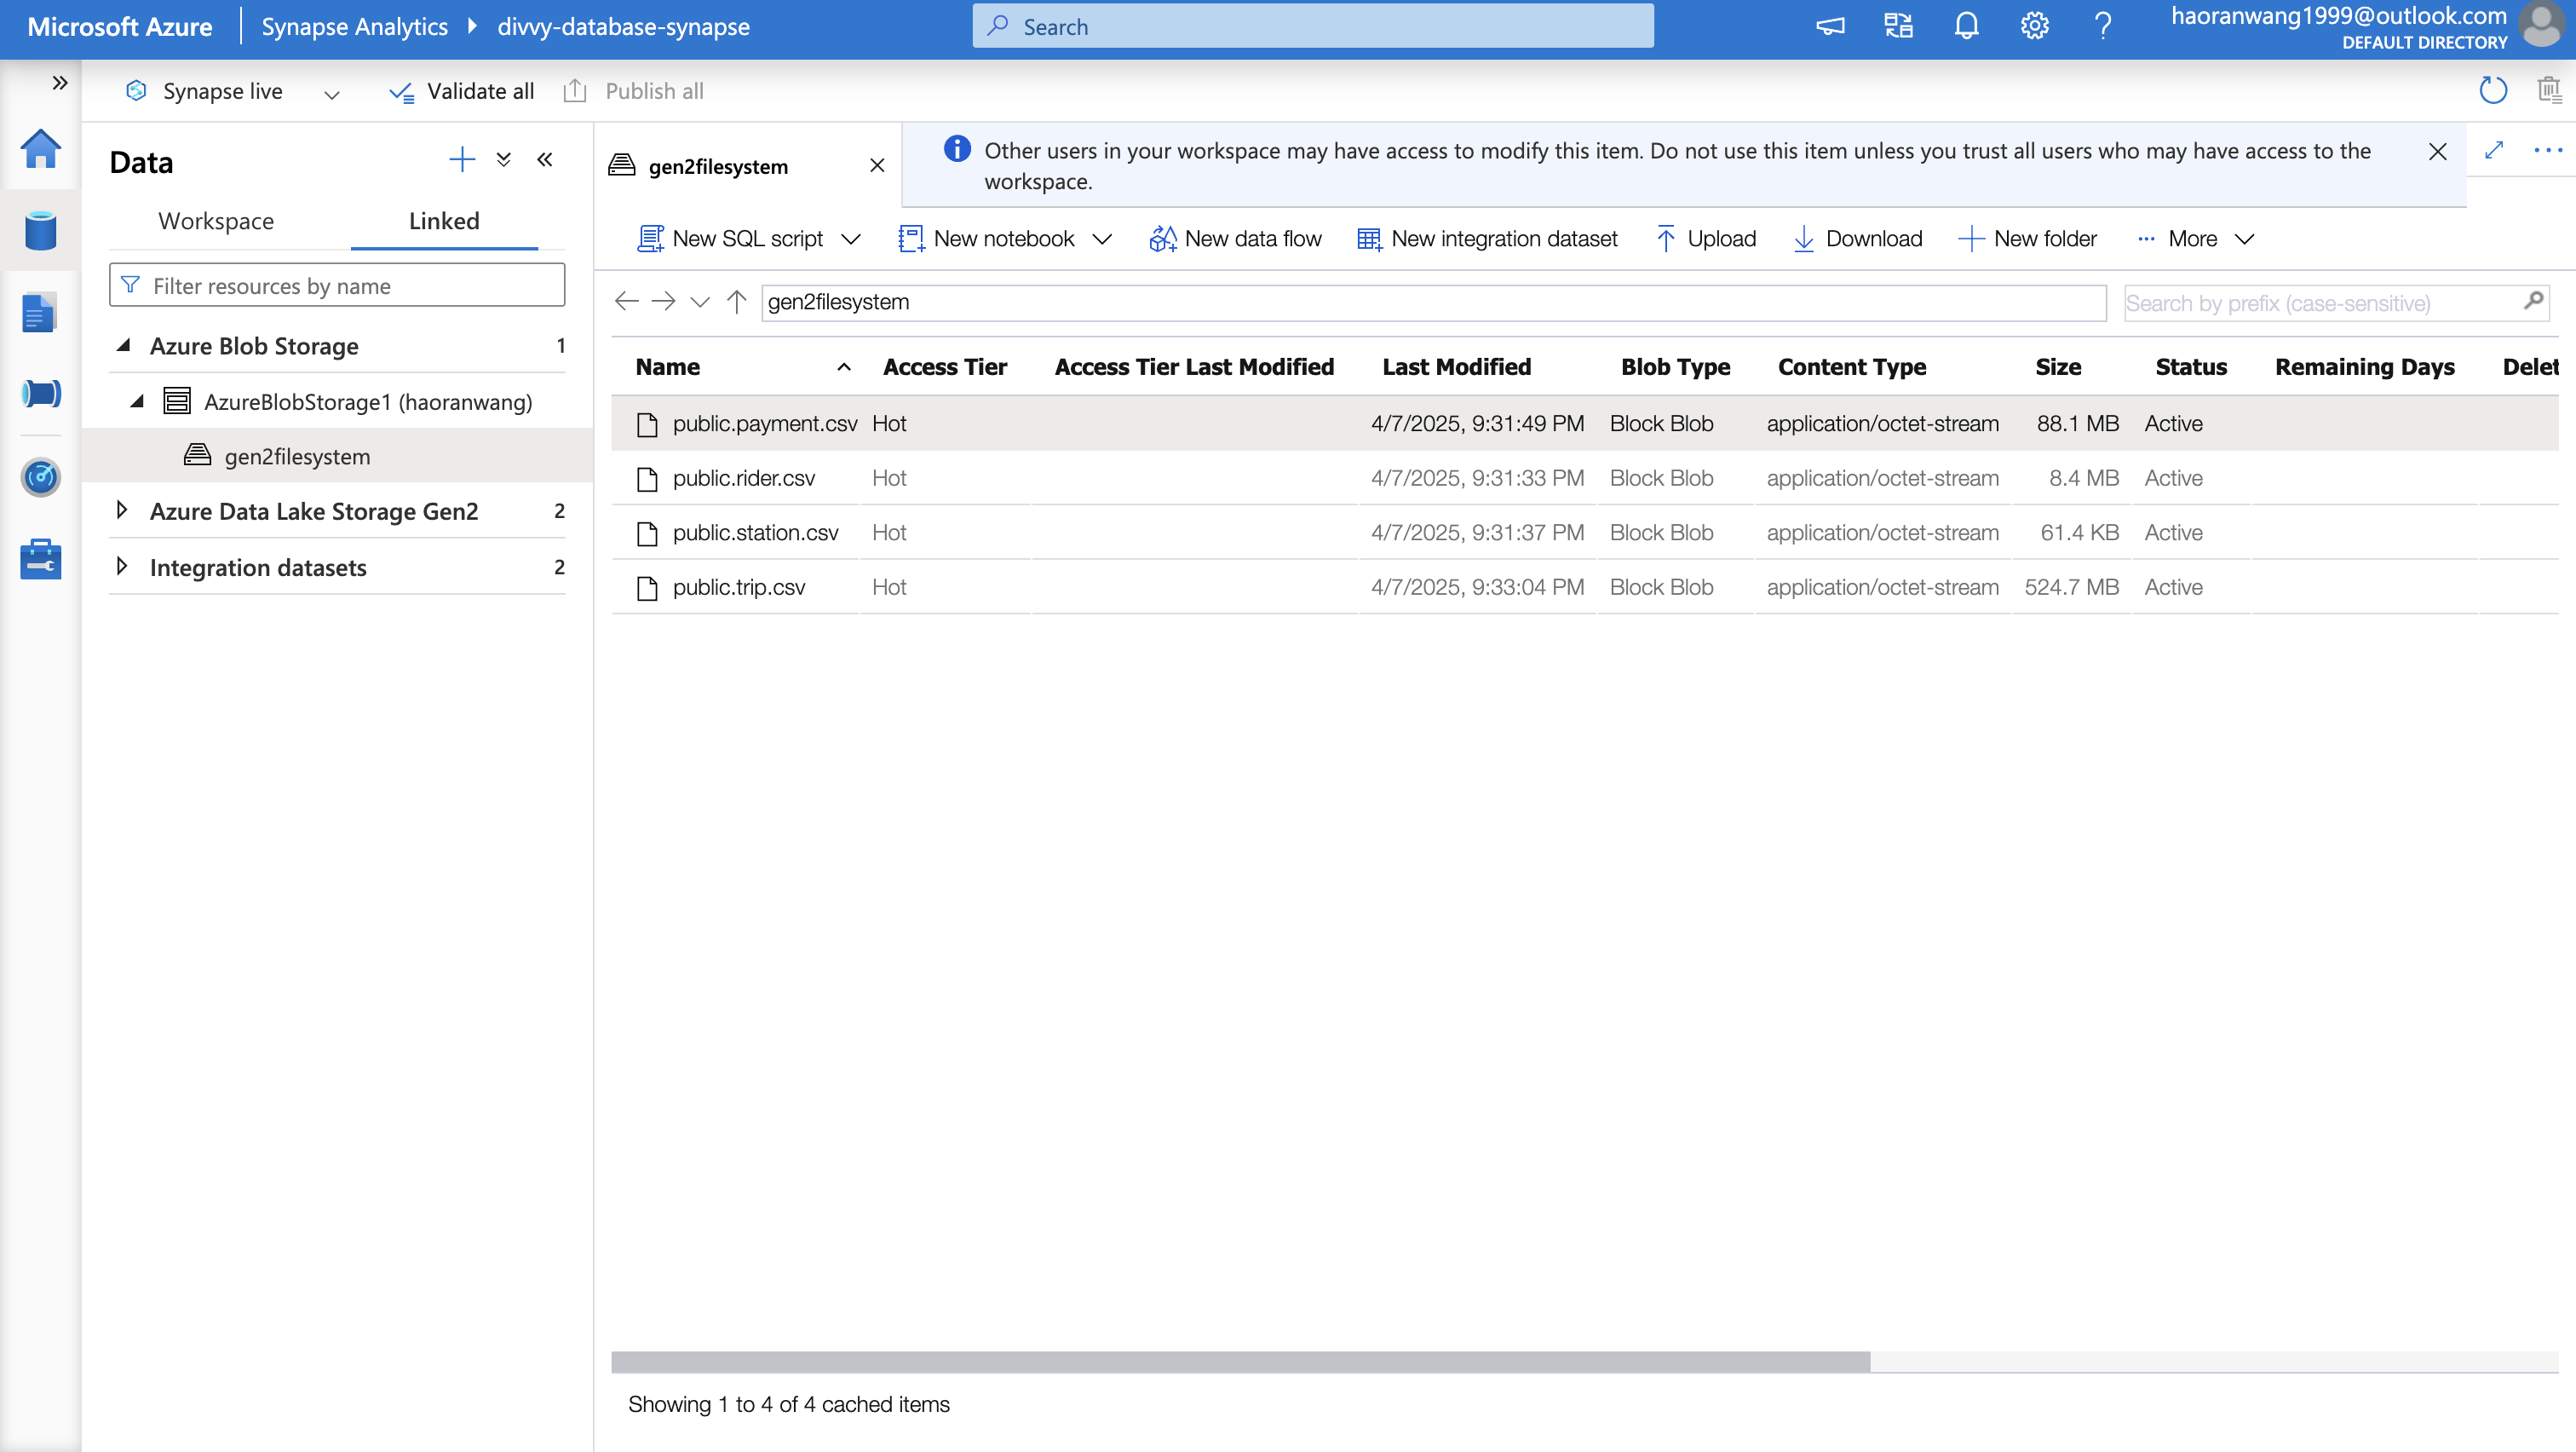

## 3. Load the data from Blob Storage into the Staging Table

In [13]:
!pip install pyodbc

In [109]:
## creating the connection to the Synapse workspace
import pyodbc
## test the package
print(pyodbc.drivers())

server = "divvy-database-synapse-ondemand.sql.azuresynapse.net"
database = "sql_divvy_database"
username = "sqladminuser"
password = "WHRdsrs:991028"
driver = "{ODBC Driver 17 for SQL Server}"  

conn = pyodbc.connect(
    f"DRIVER={driver};SERVER={server};DATABASE={database};UID={username};PWD={password};Encrypt=yes;TrustServerCertificate=no;Connection Timeout=30;"
)
cursor = conn.cursor()

['ODBC Driver 17 for SQL Server']


#### run the T-SQL transcript

In [110]:
sql_script = [
    """
    IF NOT EXISTS (SELECT * FROM sys.external_file_formats WHERE name = 'SynapseDelimitedTextFormat') 
	CREATE EXTERNAL FILE FORMAT [SynapseDelimitedTextFormat] 
	WITH ( FORMAT_TYPE = DELIMITEDTEXT ,
	       FORMAT_OPTIONS (
			 FIELD_TERMINATOR = ',',
			 USE_TYPE_DEFAULT = FALSE
			))
    """,
    """
    IF NOT EXISTS (SELECT * FROM sys.external_data_sources WHERE name = 'gen2filesystem_haoranwang_dfs_core_windows_net') 
	CREATE EXTERNAL DATA SOURCE [gen2filesystem_haoranwang_dfs_core_windows_net] 
	WITH (
		LOCATION = 'abfss://gen2filesystem@haoranwang.dfs.core.windows.net' 
	)
    """,
    """
    CREATE EXTERNAL TABLE dbo.staging_payment (
	[PaymentId] bigint,
	[Date] datetime2(0),
	[Amount] float,
	[RiderId] bigint
	)
	WITH (
	LOCATION = 'payment.csv',
	DATA_SOURCE = [gen2filesystem_haoranwang_dfs_core_windows_net],
	FILE_FORMAT = [SynapseDelimitedTextFormat]
	)
    """]


for stmt in sql_script:
    try:
        cursor.execute(stmt)
        if cursor.description:  # means it's a SELECT or result-returning query
            rows = cursor.fetchall()
            for row in rows:
                print(row)
        conn.commit()
    except Exception as e:
        print(f"Error running statement:\n{stmt}\n{e}\n")


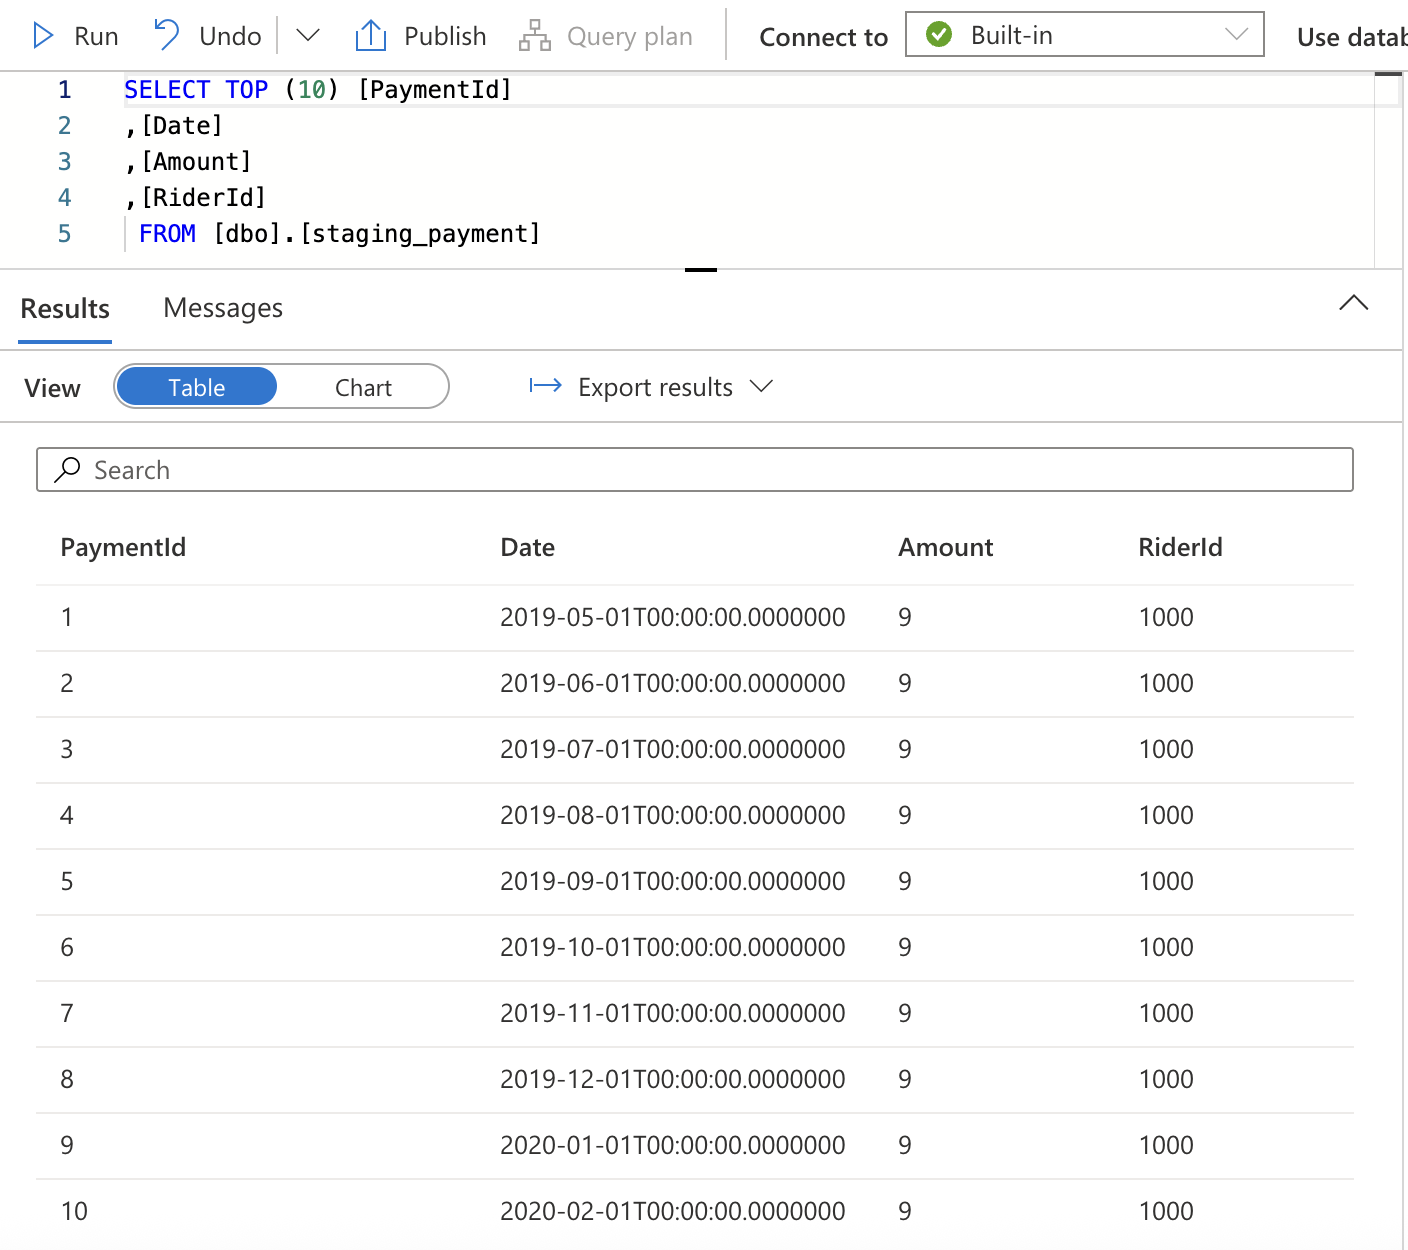
**repeat the above procedure, create the rest three staging tables**

In [112]:
sql_script = [
    """
    IF NOT EXISTS (SELECT * FROM sys.external_file_formats WHERE name = 'SynapseDelimitedTextFormat') 
	CREATE EXTERNAL FILE FORMAT [SynapseDelimitedTextFormat] 
	WITH ( FORMAT_TYPE = DELIMITEDTEXT ,
	       FORMAT_OPTIONS (
			 FIELD_TERMINATOR = ',',
			 USE_TYPE_DEFAULT = FALSE
			));
    """,
    """
    IF NOT EXISTS (SELECT * FROM sys.external_data_sources WHERE name = 'gen2filesystem_haoranwang_dfs_core_windows_net') 
	CREATE EXTERNAL DATA SOURCE [gen2filesystem_haoranwang_dfs_core_windows_net] 
	WITH (
		LOCATION = 'abfss://gen2filesystem@haoranwang.dfs.core.windows.net' 
	);
    """,
    """
    CREATE EXTERNAL TABLE dbo.staging_trip (
	[trip_id] nvarchar(500),
	[rideable_type] nvarchar(500),
	[started_at] datetime2(0),
	[ended_at] datetime2(0),
	[start_station_id] nvarchar(500),
	[end_station_id] nvarchar(500),
	[member_id] bigint
	)
	WITH (
	LOCATION = 'trip.csv',
	DATA_SOURCE = [gen2filesystem_haoranwang_dfs_core_windows_net],
	FILE_FORMAT = [SynapseDelimitedTextFormat]
	)
    """]

for stmt in sql_script:
    try:
        cursor.execute(stmt)
        if cursor.description:  # means it's a SELECT or result-returning query
            rows = cursor.fetchall()
            for row in rows:
                print(row)
        conn.commit()
    except Exception as e:
        print(f"Error running statement:\n{stmt}\n{e}\n")

select top 10 entries from the trip table
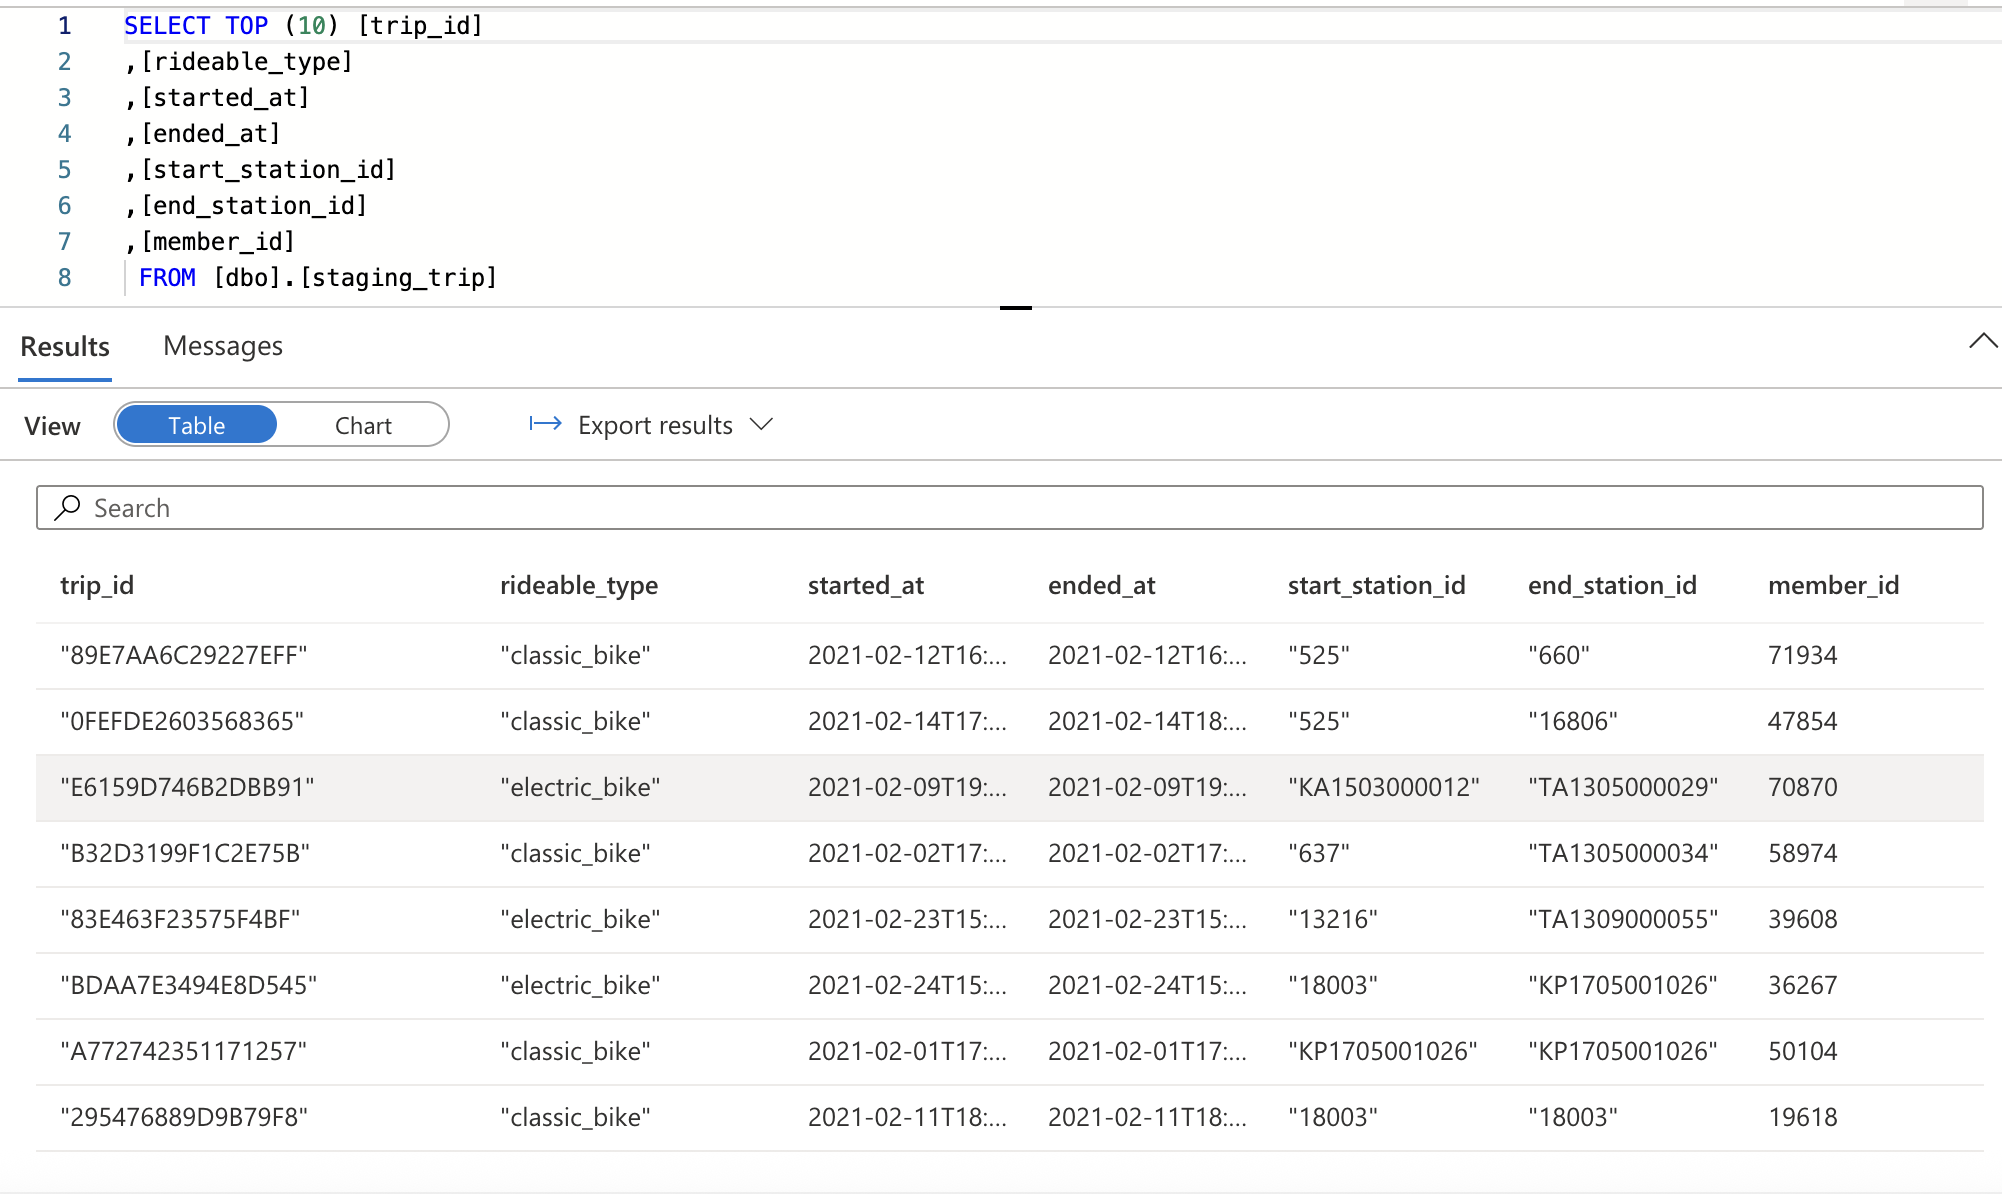

In [107]:
sql_script = [
    """
    IF NOT EXISTS (SELECT * FROM sys.external_file_formats WHERE name = 'SynapseDelimitedTextFormat') 
	CREATE EXTERNAL FILE FORMAT [SynapseDelimitedTextFormat] 
	WITH ( FORMAT_TYPE = DELIMITEDTEXT ,
	       FORMAT_OPTIONS (
			 FIELD_TERMINATOR = ',',
			 USE_TYPE_DEFAULT = FALSE
			));
    """,
    """
    IF NOT EXISTS (SELECT * FROM sys.external_data_sources WHERE name = 'gen2filesystem_haoranwang_dfs_core_windows_net') 
	CREATE EXTERNAL DATA SOURCE [gen2filesystem_haoranwang_dfs_core_windows_net] 
	WITH (
		LOCATION = 'abfss://gen2filesystem@haoranwang.dfs.core.windows.net' 
	);
    """,
    """
    CREATE EXTERNAL TABLE dbo.staging_rider (
	[rider_id] bigint,
	[first_name] nvarchar(500),
	[last_name] nvarchar(500),
	[address] nvarchar(500),
	[birthday] datetime2(0),
	[start_date] datetime2(0),
	[end_date] datetime2(0),
	[Member] bit
	)
	WITH (
	LOCATION = 'rider.csv',
	DATA_SOURCE = [gen2filesystem_haoranwang_dfs_core_windows_net],
	FILE_FORMAT = [SynapseDelimitedTextFormat]
	);
    """
]

for stmt in sql_script:
    try:
        cursor.execute(stmt)
        if cursor.description:  # means it's a SELECT or result-returning query
            rows = cursor.fetchall()
            for row in rows:
                print(row)
        conn.commit()
    except Exception as e:
        print(f"Error running statement:\n{stmt}\n{e}\n")


select top 10 to check the query
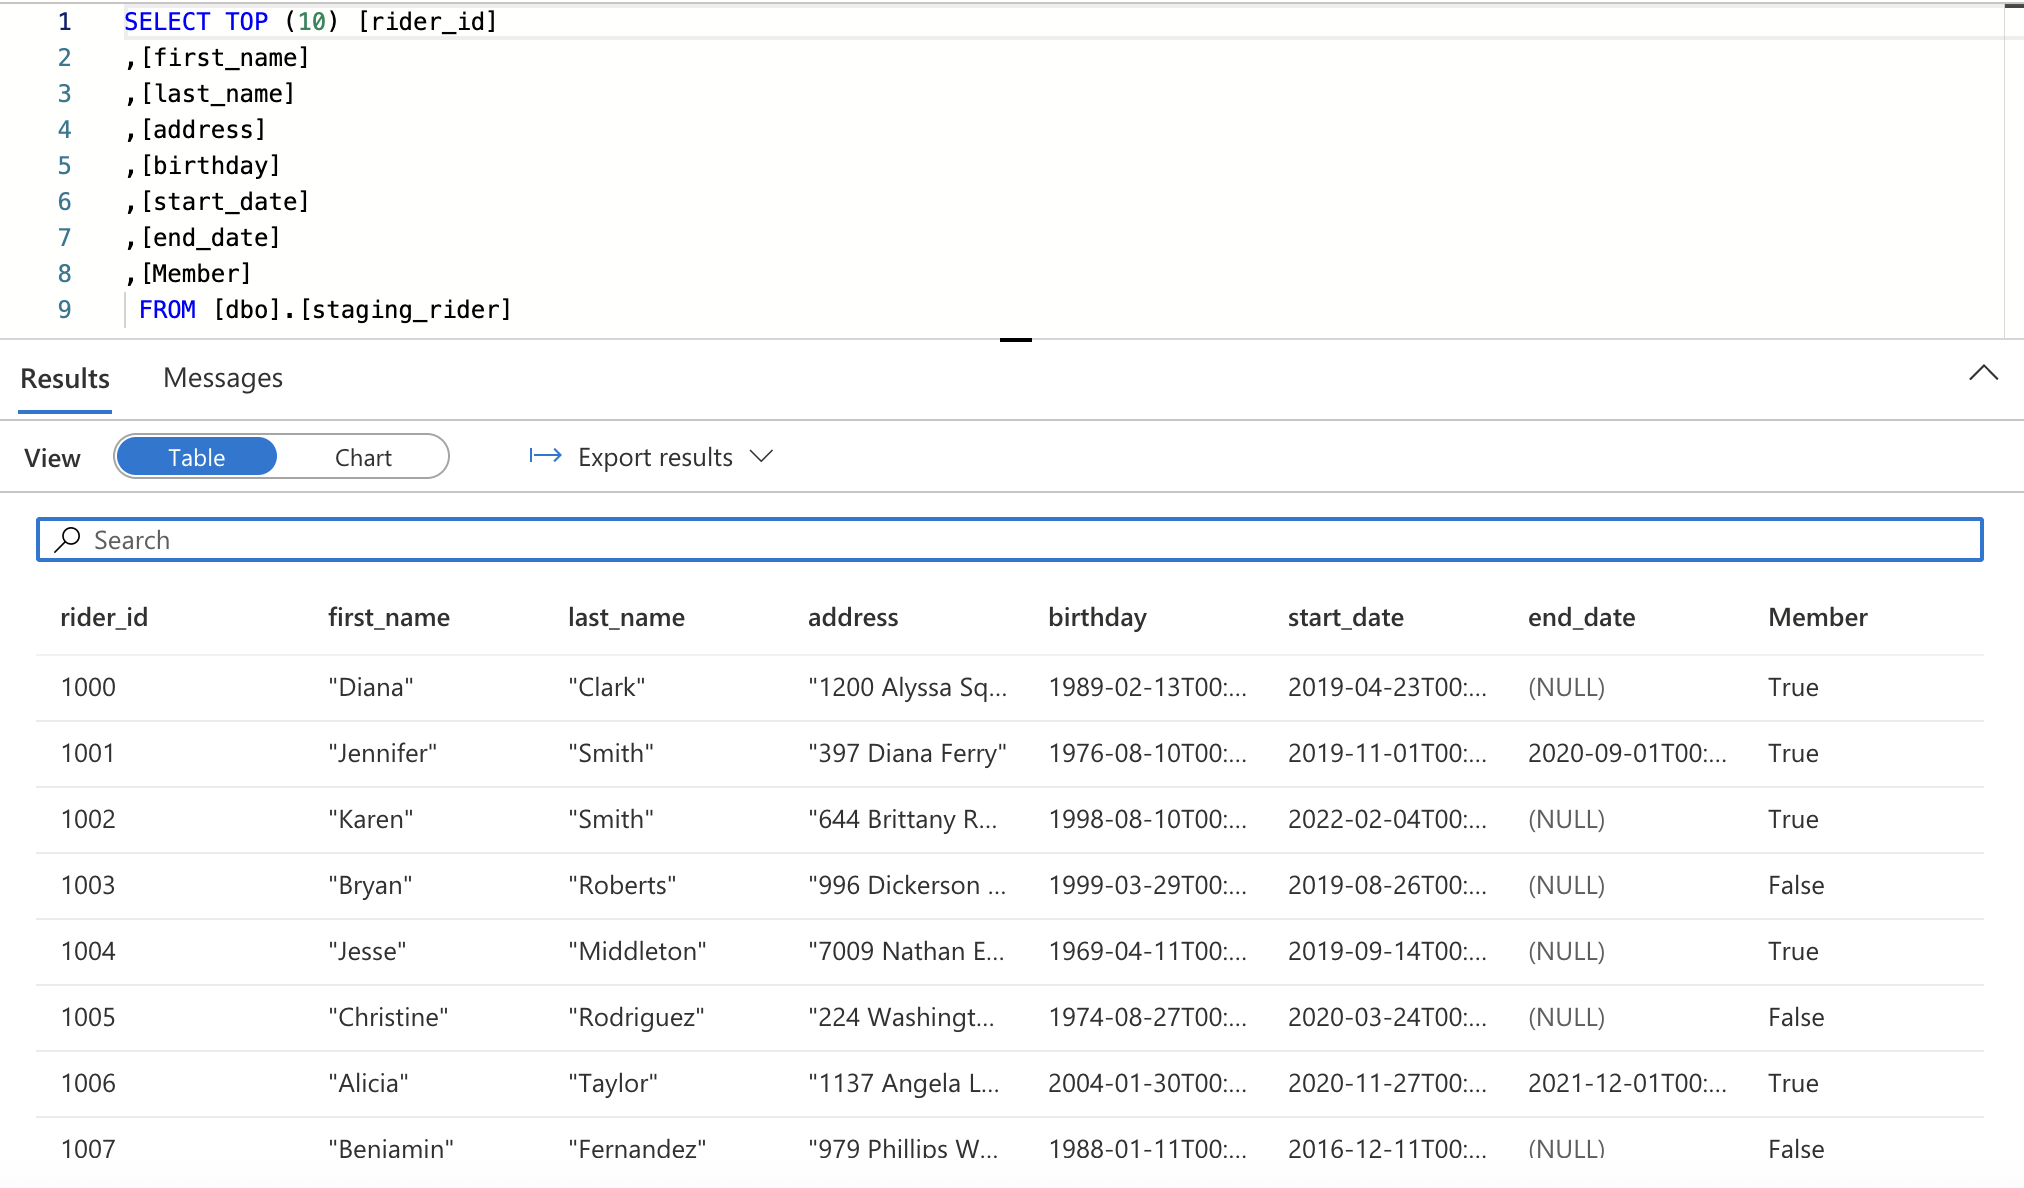

In [111]:
sql_script = [
    """
    IF NOT EXISTS (SELECT * FROM sys.external_file_formats WHERE name = 'SynapseDelimitedTextFormat') 
	CREATE EXTERNAL FILE FORMAT [SynapseDelimitedTextFormat] 
	WITH ( FORMAT_TYPE = DELIMITEDTEXT ,
	       FORMAT_OPTIONS (
			 FIELD_TERMINATOR = ',',
			 USE_TYPE_DEFAULT = FALSE
			));
    """,
    """
    IF NOT EXISTS (SELECT * FROM sys.external_data_sources WHERE name = 'gen2filesystem_haoranwang_dfs_core_windows_net') 
	CREATE EXTERNAL DATA SOURCE [gen2filesystem_haoranwang_dfs_core_windows_net] 
	WITH (
		LOCATION = 'abfss://gen2filesystem@haoranwang.dfs.core.windows.net' 
	);
    """,
    """
    CREATE EXTERNAL TABLE dbo.staging_station (
	[StationId] nvarchar(500),
	[name] nvarchar(500),
	[latitude] float,
	[longtitude] float
	)
	WITH (
	LOCATION = 'station.csv',
	DATA_SOURCE = [gen2filesystem_haoranwang_dfs_core_windows_net],
	FILE_FORMAT = [SynapseDelimitedTextFormat]
	);
    """
]

for stmt in sql_script:
    try:
        cursor.execute(stmt)
        if cursor.description:  # means it's a SELECT or result-returning query
            rows = cursor.fetchall()
            for row in rows:
                print(row)
        conn.commit()
    except Exception as e:
        print(f"Error running statement:\n{stmt}\n{e}\n")



In [4]:
## clean up the connection
cursor.close()
conn.close()

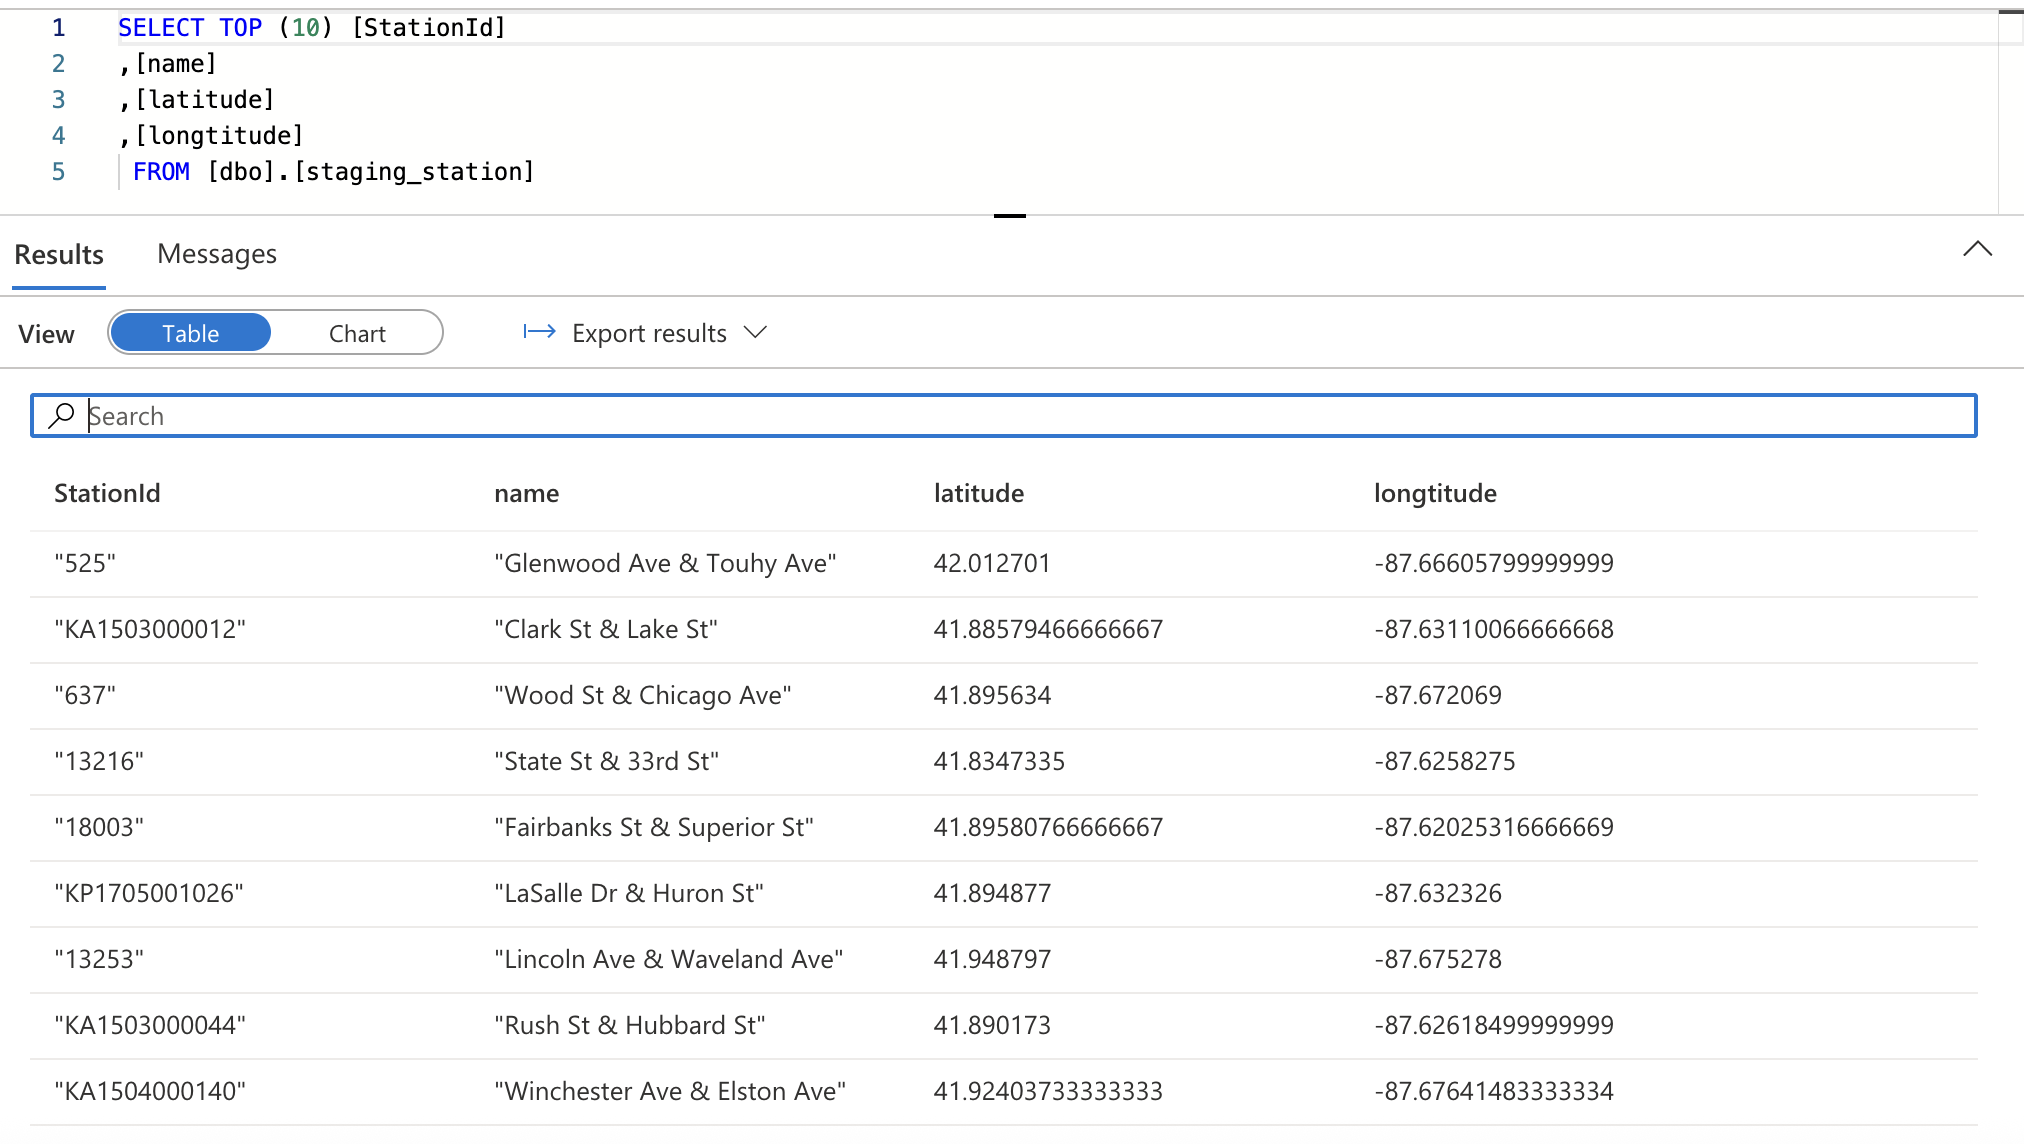

**All the data has been successfully loaded into Blob Storage. We will now use the staging tables in the Gen2 Data Lake to transform the data schemas into star schemas, completing the TRANSFORM step.**

## 4. Transform the staging tables into the star schema illustrated above to facilitate the OLAP process.

### the following T-SQL queries ran in the Synapse Workspace

In [ ]:
## Creating the CETAS - the remodlled star schema tables

IF NOT EXISTS (SELECT * FROM sys.external_file_formats WHERE name = 'SynapseDelimitedTextFormat') 
	CREATE EXTERNAL FILE FORMAT [SynapseDelimitedTextFormat] 
	WITH ( FORMAT_TYPE = DELIMITEDTEXT ,
	       FORMAT_OPTIONS (
			 FIELD_TERMINATOR = ',',
			 USE_TYPE_DEFAULT = FALSE
			));
GO

 IF NOT EXISTS (SELECT * FROM sys.external_data_sources WHERE name = 'gen2filesystem_haoranwang_dfs_core_windows_net') 
	CREATE EXTERNAL DATA SOURCE [gen2filesystem_haoranwang_dfs_core_windows_net] 
	WITH (
		LOCATION = 'abfss://gen2filesystem@haoranwang.dfs.core.windows.net' 
	);
GO

IF OBJECT_ID('dbo.fact_payment') IS NOT NULL
    BEGIN
    DROP EXTERNAL TABLE [dbo].[fact_payment];
    END
GO

CREATE EXTERNAL TABLE dbo.fact_payment
    WITH (
    LOCATION     = 'fact_payment',
    DATA_SOURCE = [gen2filesystem_haoranwang_dfs_core_windows_net],
    FILE_FORMAT = [SynapseDelimitedTextFormat]
    )  AS
    SELECT [PaymentId], [Amount], [Date] AS [payment_date], [RiderId] AS [account_number]
    FROM [dbo].[staging_payment]
GO

SELECT TOP 10 * FROM dbo.fact_payment;
GO

**Table Demonstration**
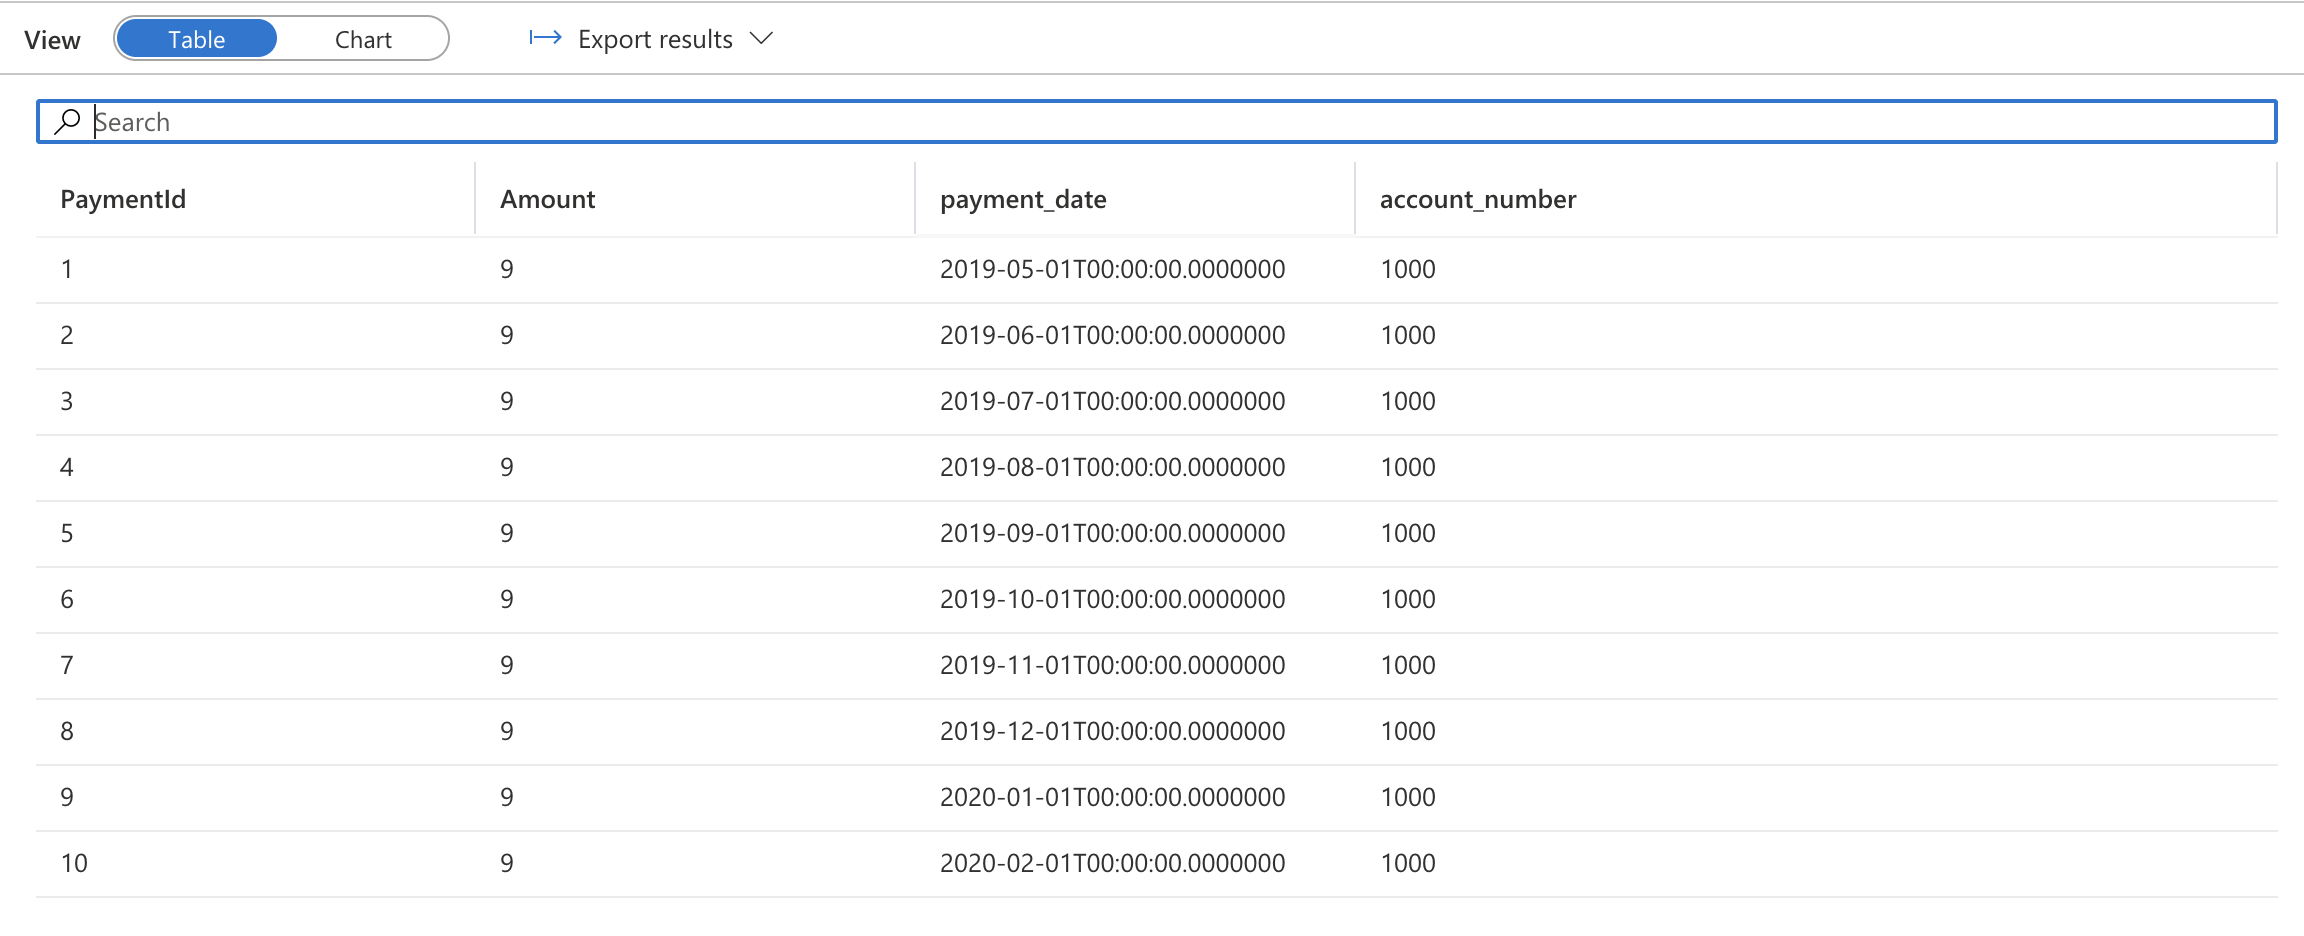

In [ ]:
IF NOT EXISTS (SELECT * FROM sys.external_file_formats WHERE name = 'SynapseDelimitedTextFormat') 
	CREATE EXTERNAL FILE FORMAT [SynapseDelimitedTextFormat] 
	WITH ( FORMAT_TYPE = DELIMITEDTEXT ,
	       FORMAT_OPTIONS (
			 FIELD_TERMINATOR = ',',
			 USE_TYPE_DEFAULT = FALSE
			));
GO

 IF NOT EXISTS (SELECT * FROM sys.external_data_sources WHERE name = 'gen2filesystem_haoranwang_dfs_core_windows_net') 
	CREATE EXTERNAL DATA SOURCE [gen2filesystem_haoranwang_dfs_core_windows_net] 
	WITH (
		LOCATION = 'abfss://gen2filesystem@haoranwang.dfs.core.windows.net' 
	);
GO

IF OBJECT_ID('dbo.fact_trip') IS NOT NULL
    BEGIN
    DROP EXTERNAL TABLE [dbo].[fact_trip];
    END
GO

CREATE EXTERNAL TABLE dbo.fact_trip
    WITH (
    LOCATION     = 'fact_trip',
    DATA_SOURCE = [gen2filesystem_haoranwang_dfs_core_windows_net],
    FILE_FORMAT = [SynapseDelimitedTextFormat]
    )  AS
    SELECT [trip_id], [started_at], [ended_at], [member_id],[start_station_id], [end_station_id], DATEDIFF(SECOND, started_at, ended_at) AS [ride_duration_seconds], [rideable_type], [birthday]
    FROM [dbo].[staging_trip] AS T JOIN [dbo].[staging_rider] AS R
    ON T.[member_id] = R.[rider_id]
GO

SELECT TOP 10 * FROM [dbo].[fact_trip];
GO

**This is the result CETAS of the fact trip table**
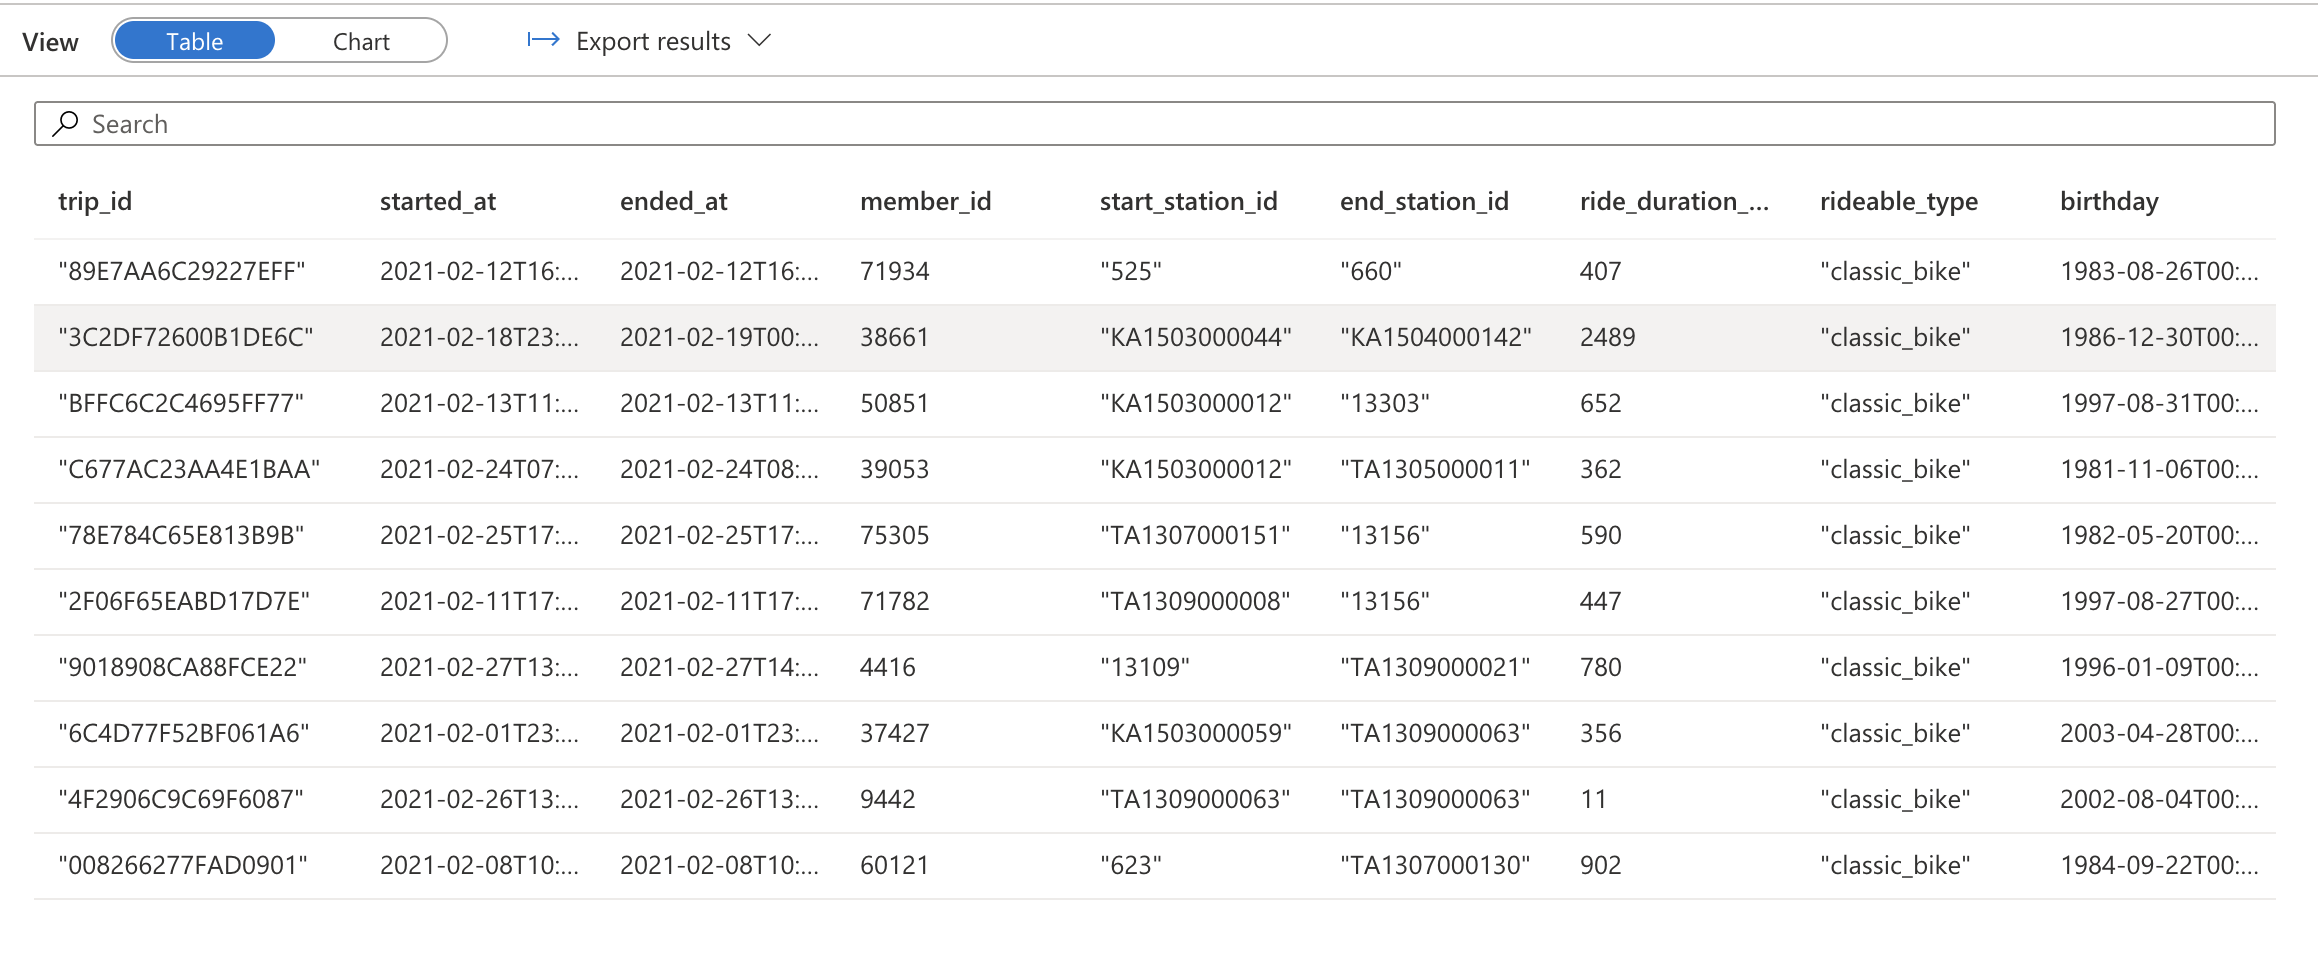

In [ ]:
IF NOT EXISTS (SELECT * FROM sys.external_file_formats WHERE name = 'SynapseDelimitedTextFormat') 
	CREATE EXTERNAL FILE FORMAT [SynapseDelimitedTextFormat] 
	WITH ( FORMAT_TYPE = DELIMITEDTEXT ,
	       FORMAT_OPTIONS (
			 FIELD_TERMINATOR = ',',
			 USE_TYPE_DEFAULT = FALSE
			));
GO

 IF NOT EXISTS (SELECT * FROM sys.external_data_sources WHERE name = 'gen2filesystem_haoranwang_dfs_core_windows_net') 
	CREATE EXTERNAL DATA SOURCE [gen2filesystem_haoranwang_dfs_core_windows_net] 
	WITH (
		LOCATION = 'abfss://gen2filesystem@haoranwang.dfs.core.windows.net' 
	);
GO

IF OBJECT_ID('dbo.dim_station') IS NOT NULL
    BEGIN
    DROP EXTERNAL TABLE [dbo].[dim_station];
    END
GO

CREATE EXTERNAL TABLE dbo.dim_station
    WITH (
    LOCATION     = 'dim_station',
    DATA_SOURCE = [gen2filesystem_haoranwang_dfs_core_windows_net],
    FILE_FORMAT = [SynapseDelimitedTextFormat]
    )  AS
    SELECT [StationId], [name], [latitude], [longtitude]
    FROM [dbo].[staging_station]
GO


SELECT TOP 10 * FROM dbo.dim_station;
GO

**Result for the Dim_station table**
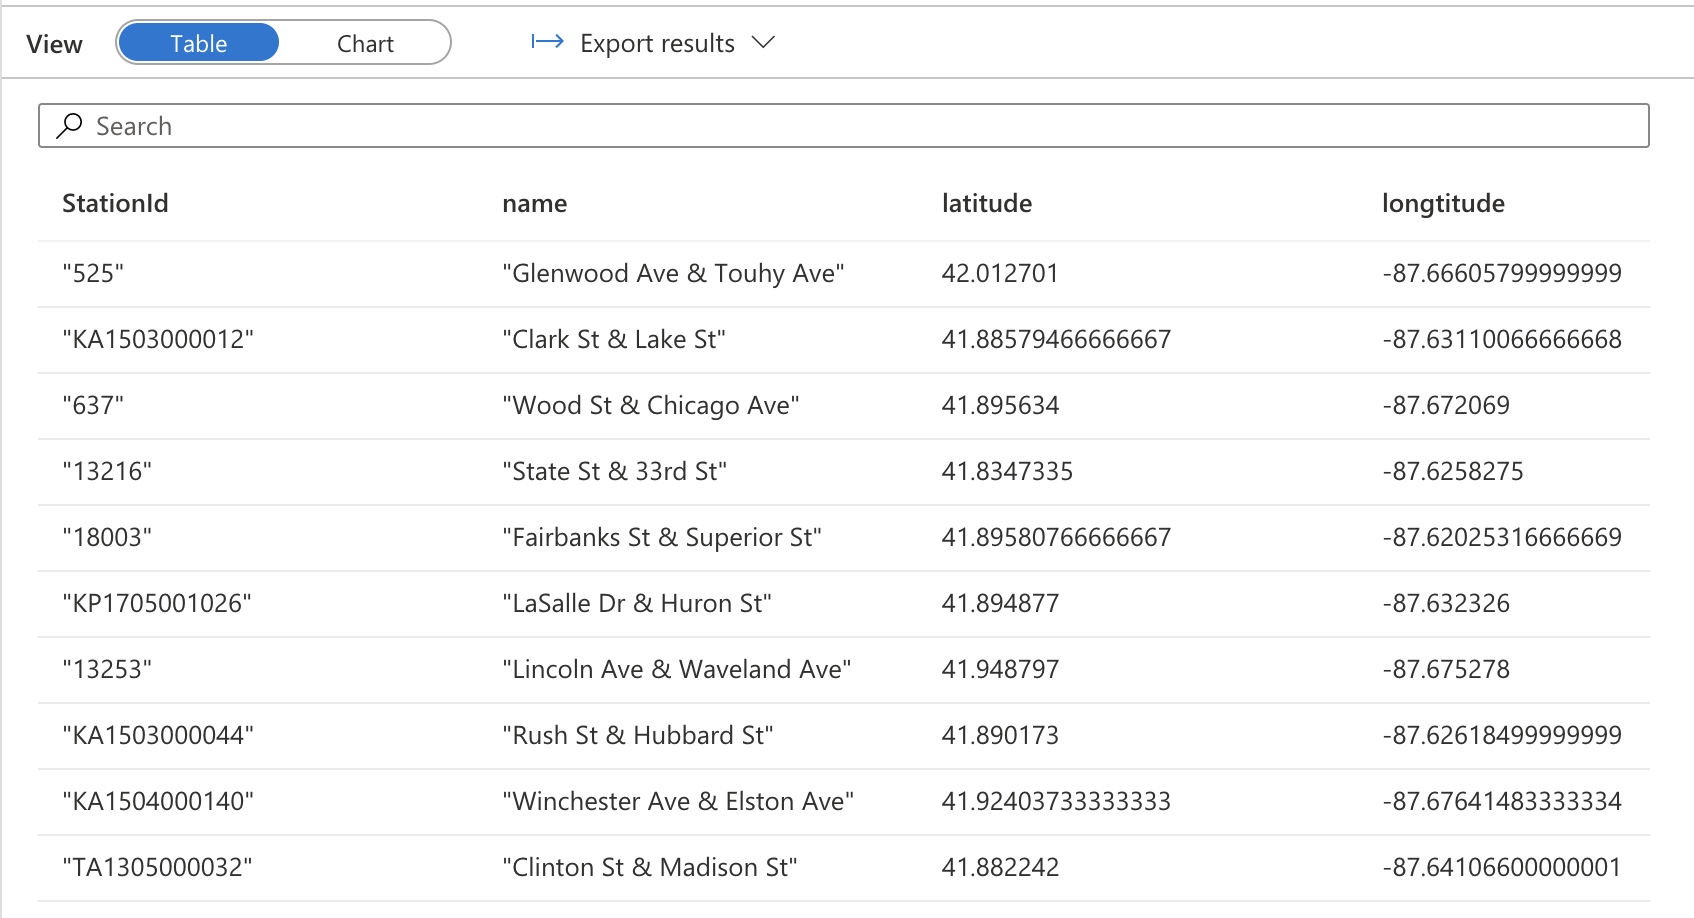

In [ ]:
IF NOT EXISTS (SELECT * FROM sys.external_file_formats WHERE name = 'SynapseDelimitedTextFormat') 
	CREATE EXTERNAL FILE FORMAT [SynapseDelimitedTextFormat] 
	WITH ( FORMAT_TYPE = DELIMITEDTEXT ,
	       FORMAT_OPTIONS (
			 FIELD_TERMINATOR = ',',
			 USE_TYPE_DEFAULT = FALSE
			));
GO

 IF NOT EXISTS (SELECT * FROM sys.external_data_sources WHERE name = 'gen2filesystem_haoranwang_dfs_core_windows_net') 
	CREATE EXTERNAL DATA SOURCE [gen2filesystem_haoranwang_dfs_core_windows_net] 
	WITH (
		LOCATION = 'abfss://gen2filesystem@haoranwang.dfs.core.windows.net' 
	);
GO

IF OBJECT_ID('dbo.dim_rider') IS NOT NULL
    BEGIN
    DROP EXTERNAL TABLE [dbo].[dim_rider];
    END
GO

CREATE EXTERNAL TABLE dbo.dim_rider
    WITH (
    LOCATION     = 'dim_rider',
    DATA_SOURCE = [gen2filesystem_haoranwang_dfs_core_windows_net],
    FILE_FORMAT = [SynapseDelimitedTextFormat]
    )  AS
    SELECT [rider_id], [first_name], [last_name], [address],[birthday],[start_date],[end_date],[member]
    FROM [dbo].[staging_rider]
GO


SELECT TOP 10 * FROM dbo.dim_rider;
GO

**Dim_Rider details**
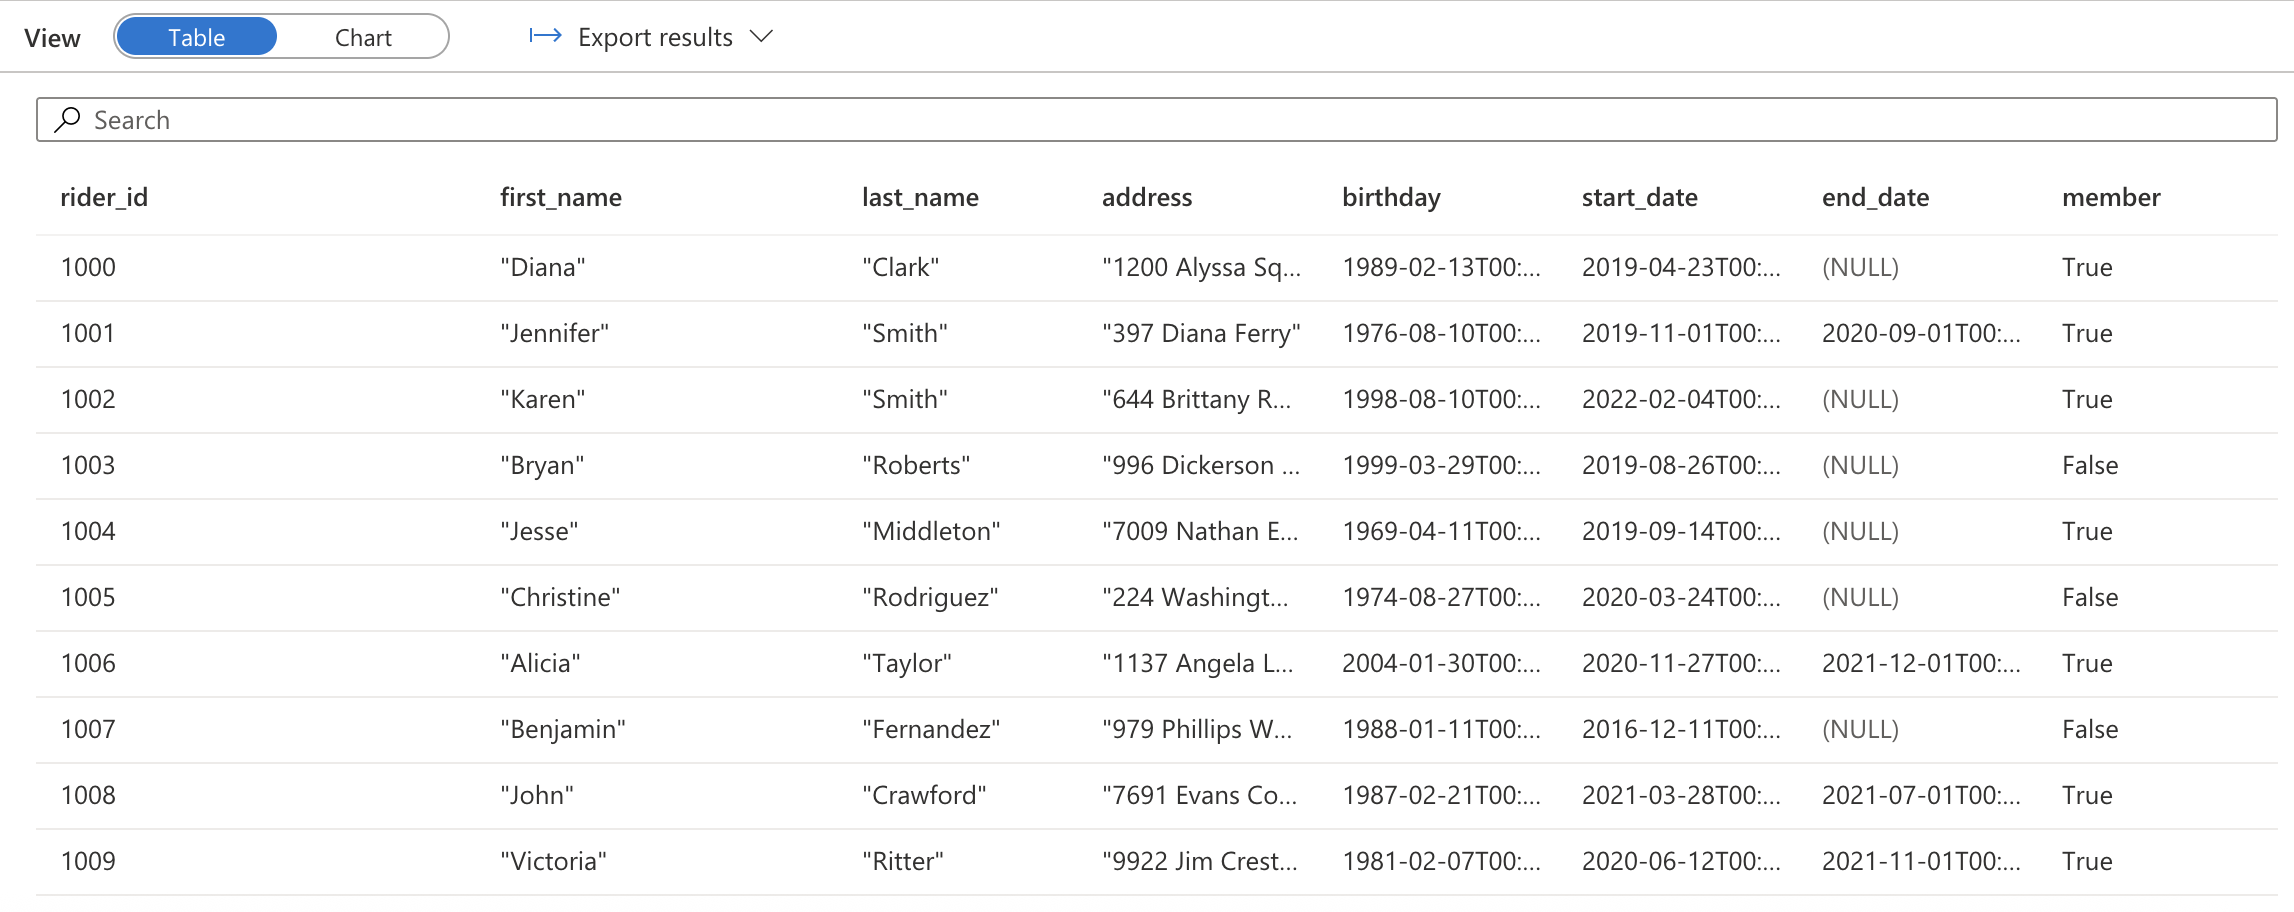

**Repeat all the steps above, create the date table**
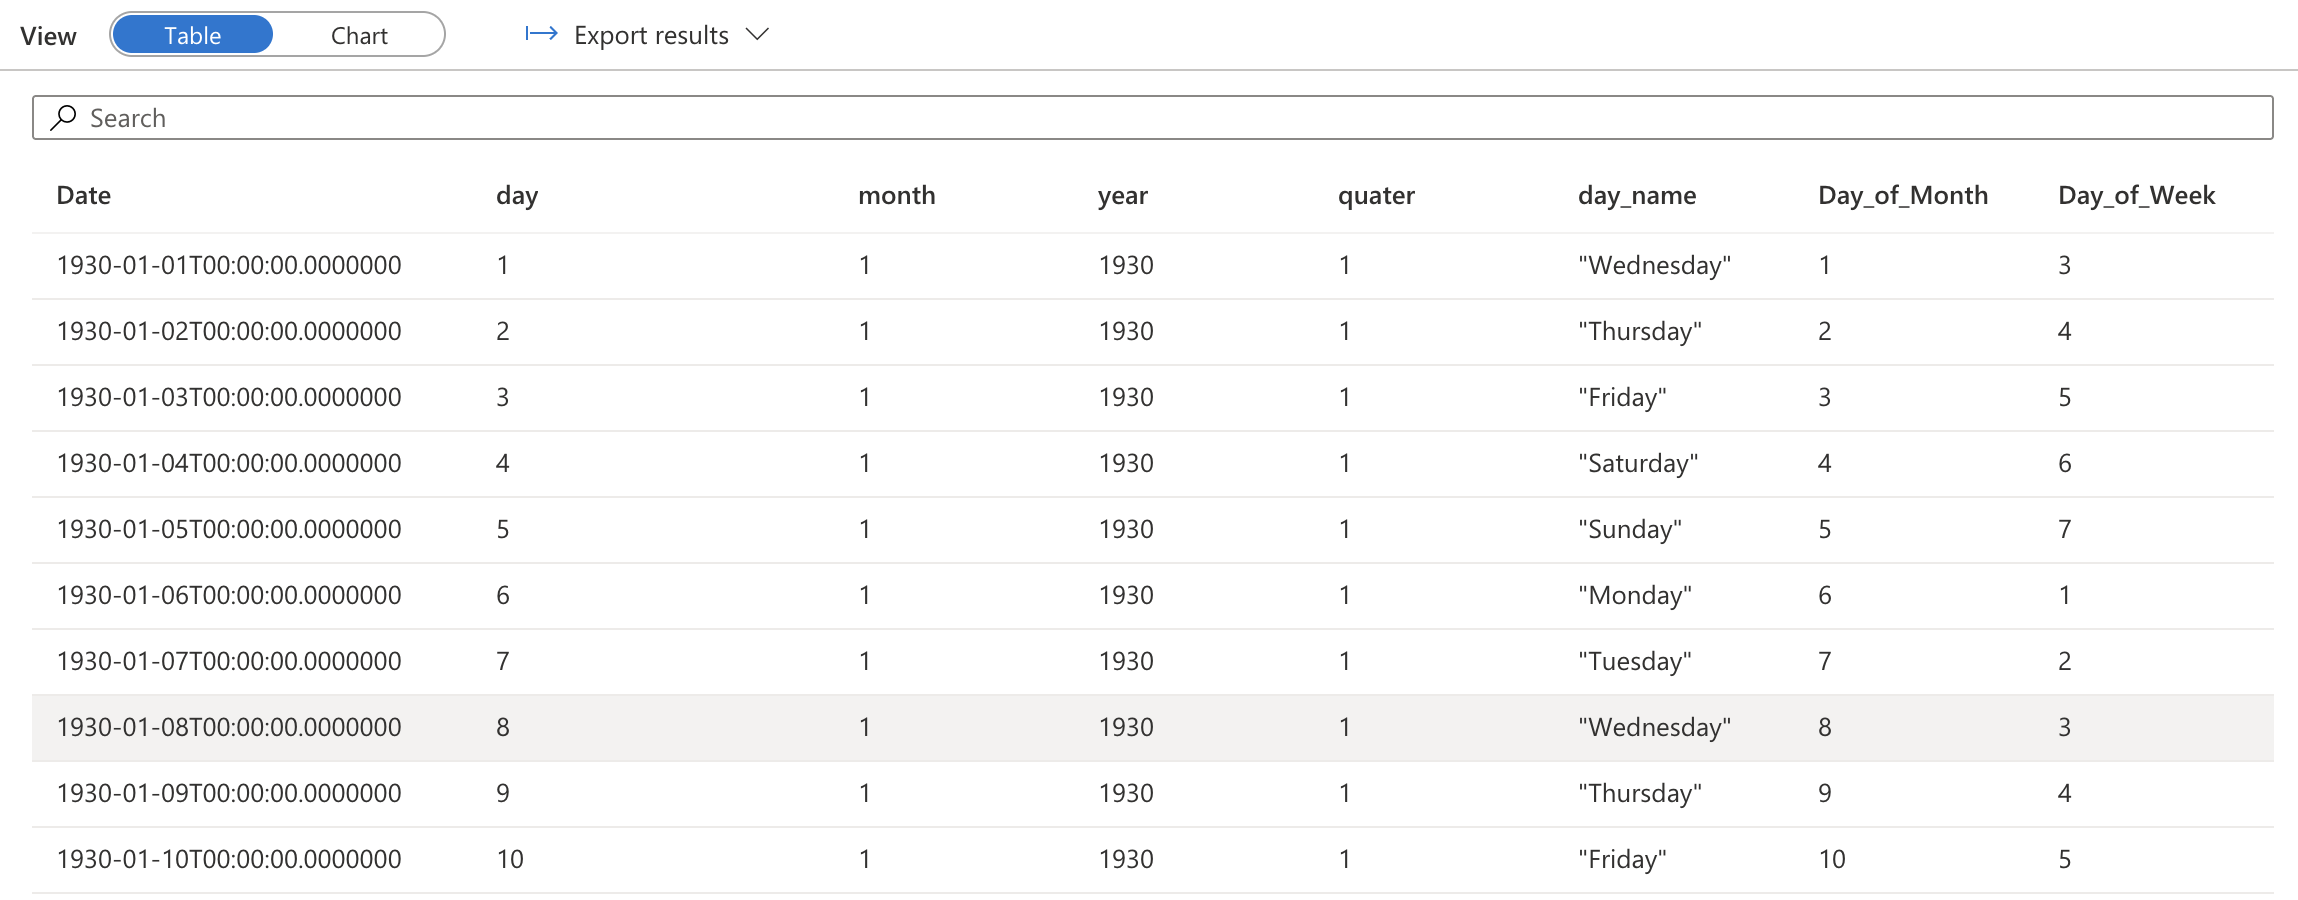

**Now we have done the remodelling for the schemas, with 2 fact tables and 3 dimension tables**
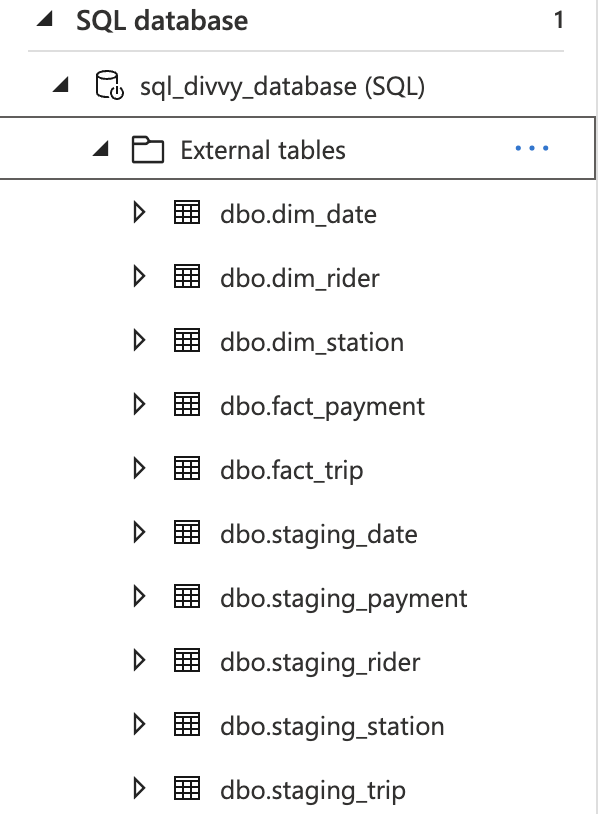